In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from IPython.core.debugger import set_trace

# we will use CUDA if it is available
USE_CUDA = torch.cuda.is_available()
DEVICE=torch.device('cuda:0') # or set to 'cpu'
print("CUDA:", USE_CUDA)
print(DEVICE)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

UNK_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"    
SOS_TOKEN = "<s>"
EOS_TOKEN = "</s>"

CUDA: True
cuda:0


In [2]:
class EncoderDecoder(nn.Module):
    '''
    a basic encoder-decoder architecture
    '''
    def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
        super(EncoderDecoder,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.trg_embed = trg_embed
        self.generator = generator
        
    def forward(self, src, trg, src_mask, trg_mask, src_lengths, trg_lengths):
        encoder_hidden, encoder_final = self.encode(src, src_mask, src_lengths)
        return self.decode(encoder_hidden, encoder_final, src_mask, trg, trg_mask)
    
    def encode(self, src, src_mask, src_lengths):
        return self.encoder(self.src_embed(src), src_mask, src_lengths)
    
    def decode(self, encoder_hidden, encoder_final, src_mask, trg, trg_mask, decoder_hidden=None):
        return self.decoder(self.trg_embed(trg), encoder_hidden, encoder_final, src_mask, trg_mask, hidden=decoder_hidden)
        

In [3]:
class Generator(nn.Module):
    '''
    linear + softmax
    '''
    def __init__(self, hidden_size, vocab_size):
        super(Generator,self).__init__()
        self.proj = nn.Linear(hidden_size, vocab_size, bias=False)
        
    def forward(self,x):
        return F.log_softmax(self.proj(x), dim=-1)

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout)
    
    def forward(self, x, mask, lengths):
        """
        Applies a bidirectional GRU to sequence of embeddings x.
        The input mini-batch x needs to be sorted by length.
        x should have dimensions [batch, time, dim].
        
        Return:
        
        output(the output of the hidden state at each time t) : (batch, seq_len, num_directions * hidden_size)
        
        final (final hidden state) : (num_layers, batch, num_directions * hidden_size)
        """
        
        packed = pack_padded_sequence(x, lengths, batch_first = True)
        output, final = self.rnn(packed)
        output, _ = pad_packed_sequence(output, batch_first=True)
        #output : (batch, seq_len, num_directions * hidden_size)
        #final :  (num_layers * num_directions, batch, hidden_size)
        
        fwd_final = final[0:final.size(0):2] #[num_layers, batch, dim]
        #from 0 to num_layers * num_directions with step 2, select forward final_hidden_state for every layer
        
        bwd_final = final[1:final.size(0):2] #[num_layers, batch, dim]
        #from 1 to num_layers * num_directions with step 2, select backward final_hidden_state for every layer
        final = torch.cat([fwd_final, bwd_final], dim=2)  # [num_layers, batch, 2*dim]
        
        return output, final
        

In [5]:
class Decoder(nn.Module):
    """A conditional RNN decoder with attention."""
    
    def __init__(self, emb_size, hidden_size, attention, num_layers=1, dropout=0.5,
                 bridge=True):
        super(Decoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = attention
        self.dropout = dropout
                 
        self.rnn = nn.GRU(emb_size + 2*hidden_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout)
                 
        # to initialize from the final encoder state
        self.bridge = nn.Linear(2*hidden_size, hidden_size, bias=True) if bridge else None

        self.dropout_layer = nn.Dropout(p=dropout)
        self.pre_output_layer = nn.Linear(hidden_size + 2*hidden_size + emb_size,
                                          hidden_size, bias=False)
        
    def forward_step(self, prev_embed, encoder_hidden, src_mask, proj_key, hidden):
        """
        Perform a single decoder step (1 word)
        
        Return : 
        pre_output : [batch_size,1,hidden_size]
        """

        # compute context vector using attention mechanism
        # hidden : last decoder hidden state
        query = hidden[-1].unsqueeze(1)  # [num_layers, batch, hidden_size] -> [batch, 1, hidden_size]
        context, attn_probs = self.attention(
            query=query, proj_key=proj_key,
            value=encoder_hidden, mask=src_mask)

        # update rnn hidden state
        #pre_embed : [batch_size,1,embed_size]
        rnn_input = torch.cat([prev_embed, context], dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        
        pre_output = torch.cat([prev_embed, output, context], dim=2)
        pre_output = self.dropout_layer(pre_output)
        pre_output = self.pre_output_layer(pre_output)

        return output, hidden, pre_output
    
    def forward(self, trg_embed, encoder_hidden, encoder_final, 
                src_mask, trg_mask, hidden=None, max_len=None):
        """Unroll the decoder one step at a time."""
                                         
        # the maximum number of steps to unroll the RNN
        if max_len is None:
            max_len = trg_mask.size(-1)

        # initialize decoder hidden state
        if hidden is None:
            hidden = self.init_hidden(encoder_final)
        
        # pre-compute projected encoder hidden states
        # (the "keys" for the attention mechanism)
        # this is only done for efficiency
        proj_key = self.attention.key_layer(encoder_hidden)
        
        # here we store all intermediate hidden states and pre-output vectors
        decoder_states = []
        pre_output_vectors = []
        
        # unroll the decoder RNN for max_len steps
        for i in range(max_len):
            #trg_embed : [batch_size, max_len]
            prev_embed = trg_embed[:, i].unsqueeze(1) #pre_embed : [batch_size,1,embed_size]
            output, hidden, pre_output = self.forward_step(
              prev_embed, encoder_hidden, src_mask, proj_key, hidden)
            decoder_states.append(output)
            pre_output_vectors.append(pre_output)

        decoder_states = torch.cat(decoder_states, dim=1)
        pre_output_vectors = torch.cat(pre_output_vectors, dim=1)
        return decoder_states, hidden, pre_output_vectors  #[batch_size, seq_len, hidden_size]

    def init_hidden(self, encoder_final):
        """Returns the initial decoder state,
        conditioned on the final encoder state."""

        if encoder_final is None:
            return None  # start with zeros

        return torch.tanh(self.bridge(encoder_final))  

In [6]:
class Batch:
    def __init__(self, src, trg, pad_index=0):
        '''
        src : [ batch_size, length-1 ] # 最开始什么都没有 最后应该是eos ??
        src_mask : [batch, 1, length-1] #不等于PAD的地方是1 等于PAD是0
        src_length : List(length of every batch(length-1)), len()=batch_size
        
        trg : [ batch_size, length-1 ] #最前面是 SOS
        trg_mask : [batch, length-2] #不等于PAD的地方是1 等于PAD是0
        trg_length : List(length of every batch(length)), len()=batch_size
        
        trg_y : [ batch_size, length-2 ] # NO EOS and SOS
        ntokens : batch_size * length-2
        nseqs : batch_size
        
        '''
        src, src_lengths = src
        
        self.src = src
        self.src_lengths = src_lengths
        self.src_mask = (src != pad_index ).unsqueeze(-2)
        self.nseqs = src.size(0)
        
        self.trg = None
        self.trg_y = None
        self.trg_mask = None
        self.trg_lengths = None
        self.ntokens = None
        
        if trg is not None :
            trg, trg_lengths = trg
            self.trg = trg[:,:-1] # 去掉最后一列
            self.trg_lengths = trg_lengths
            self.trg_y = trg[:,1:]
            self.trg_mask = (self.trg_y != pad_index)
            self.ntokens = (self.trg_y != pad_index).data.sum().item()
        
        if USE_CUDA : 
            self.src = self.src.cuda()
            self.src_mask = self.src_mask.cuda()
            
            if trg is not None:
                self.trg = self.trg.cuda()
                self.trg_y = self.trg_y.cuda()
                self.trg_mask = self.trg_mask.cuda()

In [7]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size, key_size=None, querry_size=None):
        super(BahdanauAttention,self).__init__()
        
        #a bi-directional encoder so key_size is 2*hidden_size 
        key_size = 2 * hidden_size if key_size is None else key_size
        querry_size = hidden_size if querry_size is None else querry_size
        
        self.key_layer = nn.Linear(key_size, hidden_size, bias=False)
        self.querry_layer = nn.Linear(querry_size, hidden_size, bias=False)
        self.energy_layer = nn.Linear(hidden_size, 1, bias=False)
        
        # to store attention scores
        self.alphas = None
    
    def forward(self, query=None, proj_key=None, value=None, mask=None):
        assert mask is not None, "mask is required" 
        # mask 不能为空 
        
        # we first project the query (the decoder state)
        # the projected keys (the encoder states) were already pre-computed
        query = self.querry_layer(query)
        
        #calculate scores
        scores = self.energy_layer(torch.tanh(query + proj_key))
        
        #0，1，2 把第二维是1去掉 在第一维加1
        scores = scores.squeeze(2).unsqueeze(1)
        
        # mask out invalid positions
        # the mask marks valid positions so we invert it using 'mask & 0'
        scores.data.masked_fill_(mask==0, -float('inf'))
        
        #turn scores to probabilities.
        alphas = F.softmax(scores, dim=-1)
        self.alphas = alphas
        
        context = torch.bmm(alphas, value)
        
        #context shape : [Batch_size, 1, 2*hidden_size]
        #alphas shape : [Batch_size, 1, seq_len]
        return context, alphas

In [8]:
def make_model(src_vocab, tgt_vocab, emb_size=256, hidden_size=512, num_layers=1, dropout=0.1):
    attention = BahdanauAttention(hidden_size)
    
    model = EncoderDecoder(
        Encoder(emb_size, hidden_size, num_layers=num_layers, dropout=dropout),
        Decoder(emb_size, hidden_size, attention, num_layers=num_layers, dropout=dropout),
        nn.Embedding(src_vocab, emb_size),
        nn.Embedding(tgt_vocab, emb_size),
        Generator(hidden_size,tgt_vocab)
    )
    
    return model.cuda() if USE_CUDA else model

In [9]:
def run_epoch(data_iter, model, loss_compute, print_every=50):
    
    start = time.time()
    total_tokens = 0
    total_loss = 0
    print_tokens = 0
    
    for i, batch in enumerate(data_iter, 1):
        out, _, pre_output = model.forward(batch.src, batch.trg,
                                           batch.src_mask, batch.trg_mask,
                                           batch.src_lengths, batch.trg_lengths)
        loss = loss_compute(pre_output, batch.trg_y, batch.nseqs)
        
        total_loss += loss
        total_tokens += batch.ntokens
        print_tokens += batch.ntokens
        
        if model.training and i % print_every == 0 :
            elapes = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.nseqs, print_tokens / elapes))
            start = time.time()
            print_tokens = 0 
        
    return math.exp(total_loss/float(total_tokens))

In [10]:
class SimpleLossCompute:
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1,x.size(-1)),
                             y.contiguous().view(-1))
        
        loss = loss/norm
        
        if self.opt is not None:
            loss.backward()
            self.opt.step()
            self.opt.zero_grad()
            
        return loss.data.item() * norm 

In [11]:
def greedy_decode(model, src, src_mask, src_lengths, max_len=100, sos_index=1, eos_index=None):
    
    with torch.no_grad():
        encoder_hidden, encoder_final = model.encode(src, src_mask, src_lengths)
        prev_y = torch.ones(1,1).fill_(sos_index).type_as(src)
        trg_mask = torch.ones_like(prev_y)
    
    output = []
    attention_scores = []
    hidden = None
    
    for i in range(max_len):
        with torch.no_grad():
            out, hidden, pre_output = model.decode(encoder_hidden, encoder_final, src_mask, prev_y, trg_mask, hidden)
            
            # we predict from the pre-output layer, which is a combination of decoder state, prev emb, and context
            prob = model.generator(pre_output[:,-1])
            
        _, next_word = torch.max(prob,dim =1)
        next_word = next_word.data.item()
        output.append(next_word)
        prev_y = torch.ones(1,1).type_as(src).fill_(next_word)
        attention_scores.append(model.decoder.attention.alphas.cpu().numpy())
        
    output = np.array(output)
    
    # cut off everything statring from </s>
    # only when eos_index provided
    if eos_index is not None :
        first_eos = np.where(output ==eos_index)[0]
        if len(first_eos) > 0:
            output = output[:first_eos[0]]
    return output, np.concatenate(attention_scores, axis =1)

def lookup_words(x, vocab=None):
    if vocab is not None:
        # itos 把一个整数转换为字符串
        x = [vocab.itos[i] for i in x]
    return [str(t) for t in x ]

In [12]:
# TO DO
def beamsearch_decode():
    pass

In [13]:
def print_examples(example_iter, model, n=2, max_len=100, sos_index=1, 
                   src_eos_index=None, trg_eos_index=None,
                  src_vocab=None, trg_vocab=None):
    """Prints N examples. Assumes batch size of 1."""
    
    model.eval()
    count = 0
    print()
    
    if src_vocab is not None and trg_vocab is not None :
        src_eos_index = src_vocab.stoi[EOS_TOKEN]
        trg_sos_index = trg_vocab.stoi[SOS_TOKEN]
        trg_eos_index = trg_vocab.stoi[EOS_TOKEN]
    else:
        src_eos_index = None
        trg_sos_index = 1
        trg_eos_index = None
    
    for i, batch in enumerate(example_iter):
        src = batch.src.cpu().numpy()[0,:]
        trg = batch.trg_y.cpu().numpy()[0,:]
        
        #remove </s> (if it is there)
        src = src[:-1] if src[-1] == src_eos_index else src
        trg = trg[:-1] if trg[-1] == trg_eos_index else trg
        
        result, _ = greedy_decode(
            model, batch.src, batch.src_mask, batch.src_lengths,
            max_len=max_len, sos_index=trg_sos_index, eos_index=trg_eos_index
        )
        
        print("Example #%d" % (i+1))
        print("Src : ", " ".join(lookup_words(src, vocab=src_vocab)))
        print("Trg : ", " ".join(lookup_words(trg, vocab=trg_vocab)))
        print("Pred: ", " ".join(lookup_words(result, vocab=trg_vocab)))
        print()
        
        count += 1
        if count == n:
            break

In [14]:
from torchtext import data, datasets
import spacy

UNK_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"    
SOS_TOKEN = "<s>"
EOS_TOKEN = "</s>"
LOWER = True
MAX_LEN = 25
MIN_FREQ = 5
if True :
    
    spacy_de = spacy.load('de')
    spacy_en = spacy.load('en')
    
    def tokenize_de(text):
        return [tok.text for tok in spacy_de.tokenizer(text)]
    
    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]
    
    
    
    SRC = data.Field(tokenize=tokenize_de, 
                     batch_first=True, lower=LOWER,include_lengths=True,
                    unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=SOS_TOKEN,eos_token=EOS_TOKEN)
    
    TRG = data.Field(tokenize=tokenize_en, 
                     batch_first=True, lower=LOWER, include_lengths=True,
                     unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN)
    
    train_data, valid_data, test_data = datasets.IWSLT.splits(
        exts=('.de', '.en'), fields=(SRC, TRG), 
        filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
            len(vars(x)['trg']) <= MAX_LEN)
    
    SRC.build_vocab(train_data.src, min_freq = MIN_FREQ)
    TRG.build_vocab(train_data.trg, min_freq = MIN_FREQ)
    
    PAD_INDEX = TRG.vocab.stoi[PAD_TOKEN]
    

In [15]:
def print_data_info(train_data, valid_data, test_data, src_field, trg_field):
    """ This prints some useful stuff about our data sets. """

    print("Data set sizes (number of sentence pairs):")
    print('train', len(train_data))
    print('valid', len(valid_data))
    print('test', len(test_data), "\n")

    print("First training example:")
    print("src:", " ".join(vars(train_data[0])['src']))
    print("trg:", " ".join(vars(train_data[0])['trg']), "\n")

    print("Most common words (src):")
    print("\n".join(["%10s %10d" % x for x in src_field.vocab.freqs.most_common(10)]), "\n")
    print("Most common words (trg):")
    print("\n".join(["%10s %10d" % x for x in trg_field.vocab.freqs.most_common(10)]), "\n")

    print("First 10 words (src):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(src_field.vocab.itos[:10])), "\n")
    print("First 10 words (trg):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(trg_field.vocab.itos[:10])), "\n")

    print("Number of German words (types):", len(src_field.vocab))
    print("Number of English words (types):", len(trg_field.vocab), "\n")
    
    
print_data_info(train_data, valid_data, test_data, SRC, TRG)

Data set sizes (number of sentence pairs):
train 143116
valid 690
test 963 

First training example:
src: david gallo : das ist bill lange . ich bin dave gallo .
trg: david gallo : this is bill lange . i 'm dave gallo . 

Most common words (src):
         .     138325
         ,     105944
       und      41839
       die      40809
       das      33324
       sie      33035
       ich      31153
       ist      31035
        es      27449
       wir      25817 

Most common words (trg):
         .     137259
         ,      91619
       the      73344
       and      50273
        to      42798
         a      39573
        of      39496
         i      33524
        it      32921
      that      32643 

First 10 words (src):
00 <unk>
01 <pad>
02 <s>
03 </s>
04 .
05 ,
06 und
07 die
08 das
09 sie 

First 10 words (trg):
00 <unk>
01 <pad>
02 <s>
03 </s>
04 .
05 ,
06 the
07 and
08 to
09 a 

Number of German words (types): 15762
Number of English words (types): 13003 



In [16]:
train_iter = data.BucketIterator(train_data, batch_size=128, train=True,
                                sort_within_batch=True,
                                sort_key=lambda x :(len(x.src), len(x.trg)), repeat=False,
                                device=DEVICE)
valid_iter = data.Iterator(valid_data, batch_size=1, train=False, sort=False, repeat=False, device=DEVICE)

def rebatch(pad_idx, batch):
    return Batch(batch.src, batch.trg, pad_idx)

In [17]:
def train(model, num_epochs=1, lr=0.0003, print_every=100):
    """Train a model on IWSLT"""
    
    if USE_CUDA:
        model.cuda()

    # optionally add label smoothing; see the Annotated Transformer
    criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    dev_perplexities = []

    for epoch in range(num_epochs):
      
        print("Epoch", epoch)
        model.train()
        train_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in train_iter), 
                                     model,
                                     SimpleLossCompute(model.generator, criterion, optim),
                                     print_every=print_every)
        
        model.eval()
        with torch.no_grad():
            print_examples((rebatch(PAD_INDEX, x) for x in valid_iter), 
                           model, n=3, src_vocab=SRC.vocab, trg_vocab=TRG.vocab)        

            dev_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in valid_iter), 
                                       model, 
                                       SimpleLossCompute(model.generator, criterion, None))
            print("Validation perplexity: %f" % dev_perplexity)
            dev_perplexities.append(dev_perplexity)
        
    return dev_perplexities

In [18]:
model = make_model(len(SRC.vocab), len(TRG.vocab),
                   emb_size=256, hidden_size=256,
                   num_layers=1, dropout=0.2)
dev_perplexities = train(model, print_every=100)

/home/cuihongyi19941128/anaconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 0
Epoch Step: 100 Loss: 129.366684 Tokens per Sec: 13520.394376
Epoch Step: 200 Loss: 40.538223 Tokens per Sec: 15277.545507
Epoch Step: 300 Loss: 114.885857 Tokens per Sec: 15580.349217
Epoch Step: 400 Loss: 34.839153 Tokens per Sec: 14683.912734
Epoch Step: 500 Loss: 38.983398 Tokens per Sec: 13805.155045
Epoch Step: 600 Loss: 31.550386 Tokens per Sec: 14297.136099
Epoch Step: 700 Loss: 63.275188 Tokens per Sec: 15463.767043
Epoch Step: 800 Loss: 53.533489 Tokens per Sec: 15243.236547
Epoch Step: 900 Loss: 47.404831 Tokens per Sec: 14146.720483
Epoch Step: 1000 Loss: 105.892426 Tokens per Sec: 13681.503347
Epoch Step: 1100 Loss: 72.203178 Tokens per Sec: 14495.406366

Example #1
Src :  <s> als ich 11 jahre alt war , wurde ich eines morgens von den <unk> heller freude geweckt .
Trg :  when i was 11 , i remember waking up one morning to the sound of joy in my house .
Pred:  when i was a few years ago , i was a <unk> of the <unk> of the <unk> .

Example #2
Src :  <s> mein vater hö

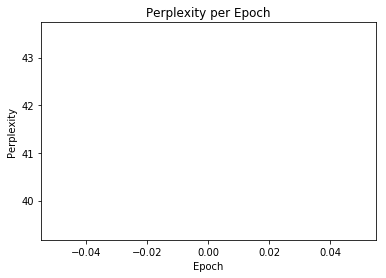

In [19]:
def plot_perplexity(perplexities):
    """plot perplexities"""
    plt.title("Perplexity per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.plot(perplexities)
    
plot_perplexity(dev_perplexities)